In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as dt
from matplotlib.dates import drange
import datetime
import requests
from scipy.optimize import curve_fit

plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)

y1 = 2023
y2 = 2023
date_format = dt.DateFormatter('%d/%m')
start_date = datetime.datetime(y1,1,1)
end_date = datetime.datetime(y2,11,15)
delta = datetime.timedelta(hours=1)
dates = drange(start_date,end_date,delta)
dates = dates[0:-1]

url = f'https://api.energidataservice.dk/dataset/ElectricityBalanceNonv?start={y1}-01-01&end={y2}-11-15&sort=HourUTC' ## DATE: yyyy-MM-dd, "yyyy-MM-ddTHH:mm"

url2 = f'https://api.energidataservice.dk/dataset/Elspotprices?start={y1}-01-01&end={y2}-11-15&sort=HourUTC' ## DATE: yyyy-MM-dd

# Make the API request
response = requests.get(url)
response.raise_for_status()  # Raise an error for bad responses

# Load data into a pandas DataFrame
data = response.json()
df = pd.DataFrame(data)

data = pd.json_normalize(df['records'])

# Make the API request
response = requests.get(url2)
response.raise_for_status()  # Raise an error for bad responses

# Load data into a pandas DataFrame
data_price = response.json()
df_price = pd.DataFrame(data_price)

data_price = pd.json_normalize(df_price['records'])

def get_price(df, string):
    area = df.loc[(df['PriceArea'] == string)]

    price = area['SpotPriceEUR']
    return np.array(price)

def get_data(df, string):
    dk1 = df.loc[(df['PriceArea'] == 'DK1')]
    dk2 = df.loc[(df['PriceArea'] == 'DK2')]

    load_1 = dk1[string].to_numpy()
    load_2 = dk2[string].to_numpy()

    #load1 = np.nan_to_num(load_1)
    #load2 = np.nan_to_num(load_1)

    total = load_1 + load_2
    
    return total
    
def return_deficit(gen, load):
    z = len(gen)
    deficit_list = []
    for i in range(z):
        deficit = 0
        if load[i] > gen[i]:
            deficit = load[i] - gen[i]
        deficit_list.append(deficit)
    return deficit_list

def return_excess(gen,load):
    z = len(gen)
    excess_list = []
    for i in range(z):
        excess = 0
        if gen[i] > load[i]:
            excess = gen[i] - load[i]
        excess_list.append(excess)
    return excess_list

In [33]:
def charge_discharge(a):
    '''
    Params
    a: scale of offshore wind power
    Return
    Lists of the storage level, the discharging and charging of the battery
    '''
    solar = get_data(data,'SolarPower')*8.1 /1000 
    wind1 = get_data(data,'OnshoreWindPower')*1.5 /1000
    wind2 = get_data(data,'OffshoreWindPower')*a /1000
    load = get_data(data,'TotalLoad')*1.6 / 1000

    z = len(solar)

    gen = wind1+wind2+solar
    deficit_list = return_deficit(gen, load)
    excess_list = return_excess(gen, load)

    storage_cap = 9 ## Storage of 36 GWh on 9 GW capacity
    storage_max = 36
    storage_list = [36]
    storage = 36 ## Storage of 36 GWh on 9 GW capacity
    discharge_list = []
    charge_list = []

    for i in range(len(gen)):
        charge = 0
        discharge = 0
        charge_need = 0
        ## Check if generation is larger than load. Charge battery if possible
        if gen[i] > load[i]:

            ## Check if the battery needs charging
            if(storage < storage_max):
                
                ## Check how much it needs to be charged
                charge_need = storage_max - storage

                ## If it needs to be charged more than the max capacity
                if charge_need > storage_cap:

                    ## Check if there is enough overproduction to charge at the maximum rate
                    if excess_list[i] > storage_cap:
                        storage += storage_cap ## Charge with maximum rate
                        charge = storage_cap
                    ## If not enough overproduction, charge it with the amount that is available
                    else:
                        storage += excess_list[i]
                        charge = excess_list[i]

                ## If it does not need to be charged more than the max capacity
                else:
                    ## If there is enough excess production, fully charge it
                    if excess_list[i] > charge_need:
                        storage += charge_need
                        charge = charge_need
                    ## If there is not enough excess production to charge it fully, then charge with whatever is available
                    else:
                        storage += excess_list[i]
                        charge = excess_list[i]

        ## If there is a deficit, discharge battery if possible
        if gen[i] < load[i]:
            ## Check if battery has more storage than deficit
            if(storage > deficit_list[i]):
                ## If deficit is larger than max output, discharge at max output
                if(deficit_list[i] > storage_cap):
                    storage -= storage_cap
                    discharge = storage_cap
                ## If deficit is smaller than max output, discharge the deficit
                else:
                    storage -= deficit_list[i]
                    discharge = deficit_list[i]
            ## If battery has less storage than deficit:
            else:
                storage -= storage
                discharge = storage

        discharge_list.append(discharge)
        storage_list.append(storage)
        charge_list.append(charge)
    storage_list.pop(0)
    return np.array(storage_list), np.array(discharge_list), np.array(charge_list)

/var/folders/r_/02xnjgc52qn74r2_bvm2dnbw0000gn/T/ipykernel_85963/1200895182.py:25: RuntimeWarning: overflow encountered in power
  return a + c*x**b


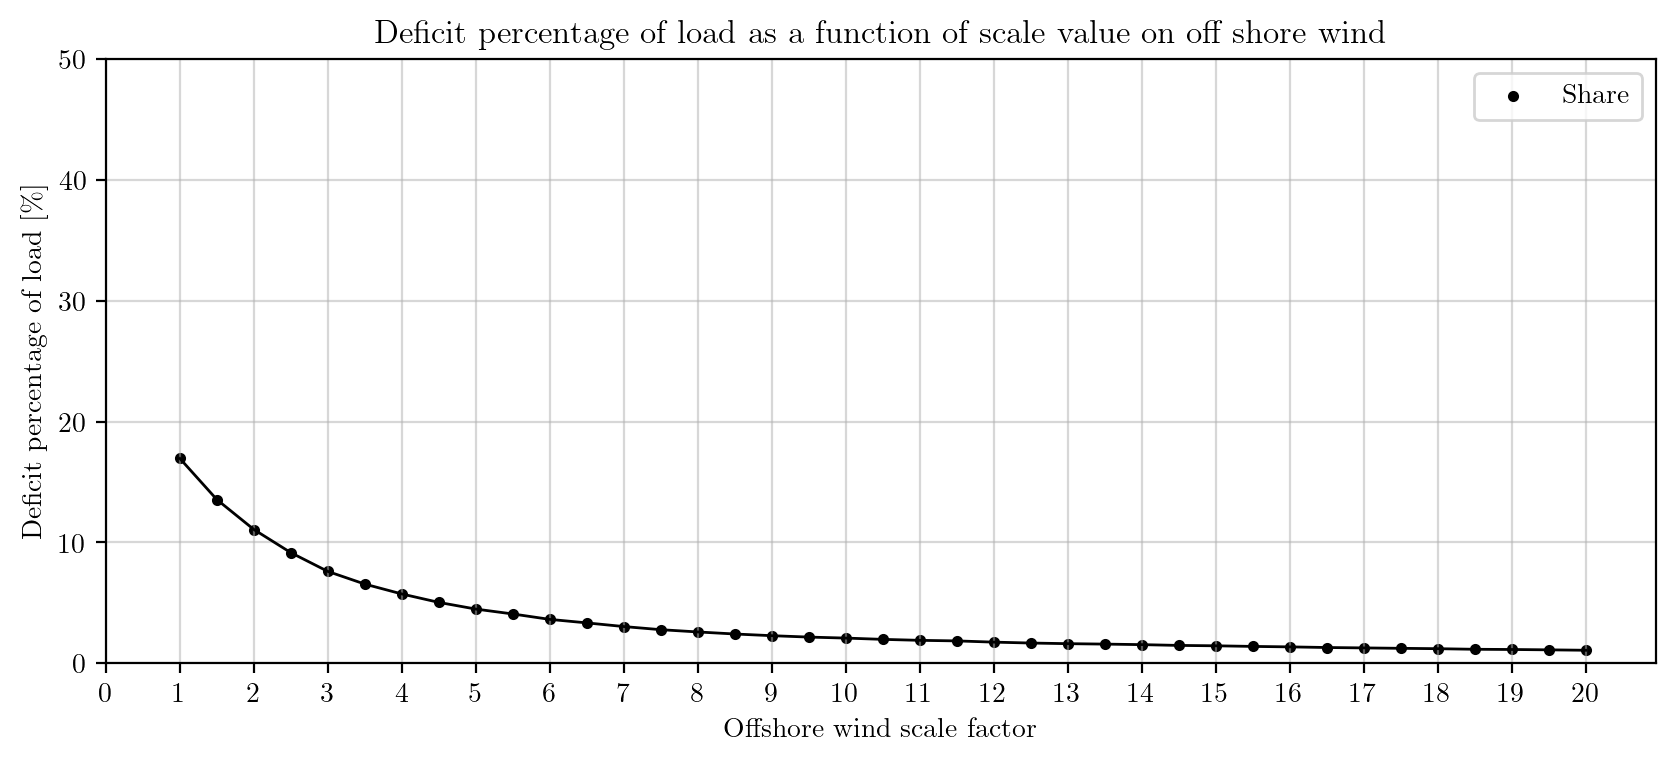

In [34]:
list_of_deficit_lists = []
rng = np.arange(1,20.5,0.5)
solar = get_data(data,'SolarPower')*8 / 1000 
wind1 = get_data(data,'OnshoreWindPower')*1.6 / 1000
load = get_data(data,'TotalLoad')*1.5 / 1000

deficit_minus_discharges_list = []

for i in rng:
    storage_list, discharge_list, charge_list = charge_discharge(i)
    wind2 = get_data(data,'OffshoreWindPower')*i / 1000
    deficit_list = return_deficit(solar+wind1+wind2,load)

    deficit_minus_discharge = deficit_list - discharge_list
    res = sum(deficit_minus_discharge)
    deficit_minus_discharges_list.append(res)

    list_of_deficit_lists.append(deficit_list)
deficits_sums = np.sum(list_of_deficit_lists,axis=1)

#def exp_fit(x,a,b, c,d):
#    return a*np.exp(x*(-b)+d)+c

def poly_fit(x,a,b,c):
    return a + c*x**b

pinit_exp=[1,-.1,1,1]
pinit_poly=[100,-50,10]

popt_poly, _ = curve_fit(poly_fit, rng, deficits_sums, p0=pinit_poly)
#popt_exp, _ = curve_fit(exp_fit, rng, deficits_sums, p0=pinit_exp)

plt.figure(dpi=200,figsize=(10,4))
plt.scatter(rng,deficit_minus_discharges_list/sum(load)*100,marker='.',color='black',label='Share')
plt.plot(rng,deficit_minus_discharges_list/sum(load)*100,color='black',linewidth=1)
#plt.plot(rng, poly_fit(rng, *popt_poly)/sum(load)*100,color='red',alpha=0.6,linestyle='--',linewidth=1, label='Power function fit')
#plt.plot(rng, exp_fit(rng, *popt_exp),color='deepskyblue',alpha=0.6,linestyle='-.',linewidth=1, label='Exponential function fit')

xs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.xticks(xs)
plt.grid(alpha=0.5)
plt.ylim(0,50)


plt.legend()
plt.ylabel('Deficit percentage of load [\%]')
plt.xlabel('Offshore wind scale factor')

plt.title('Deficit percentage of load as a function of scale value on off shore wind')
plt.savefig('curve.pdf')

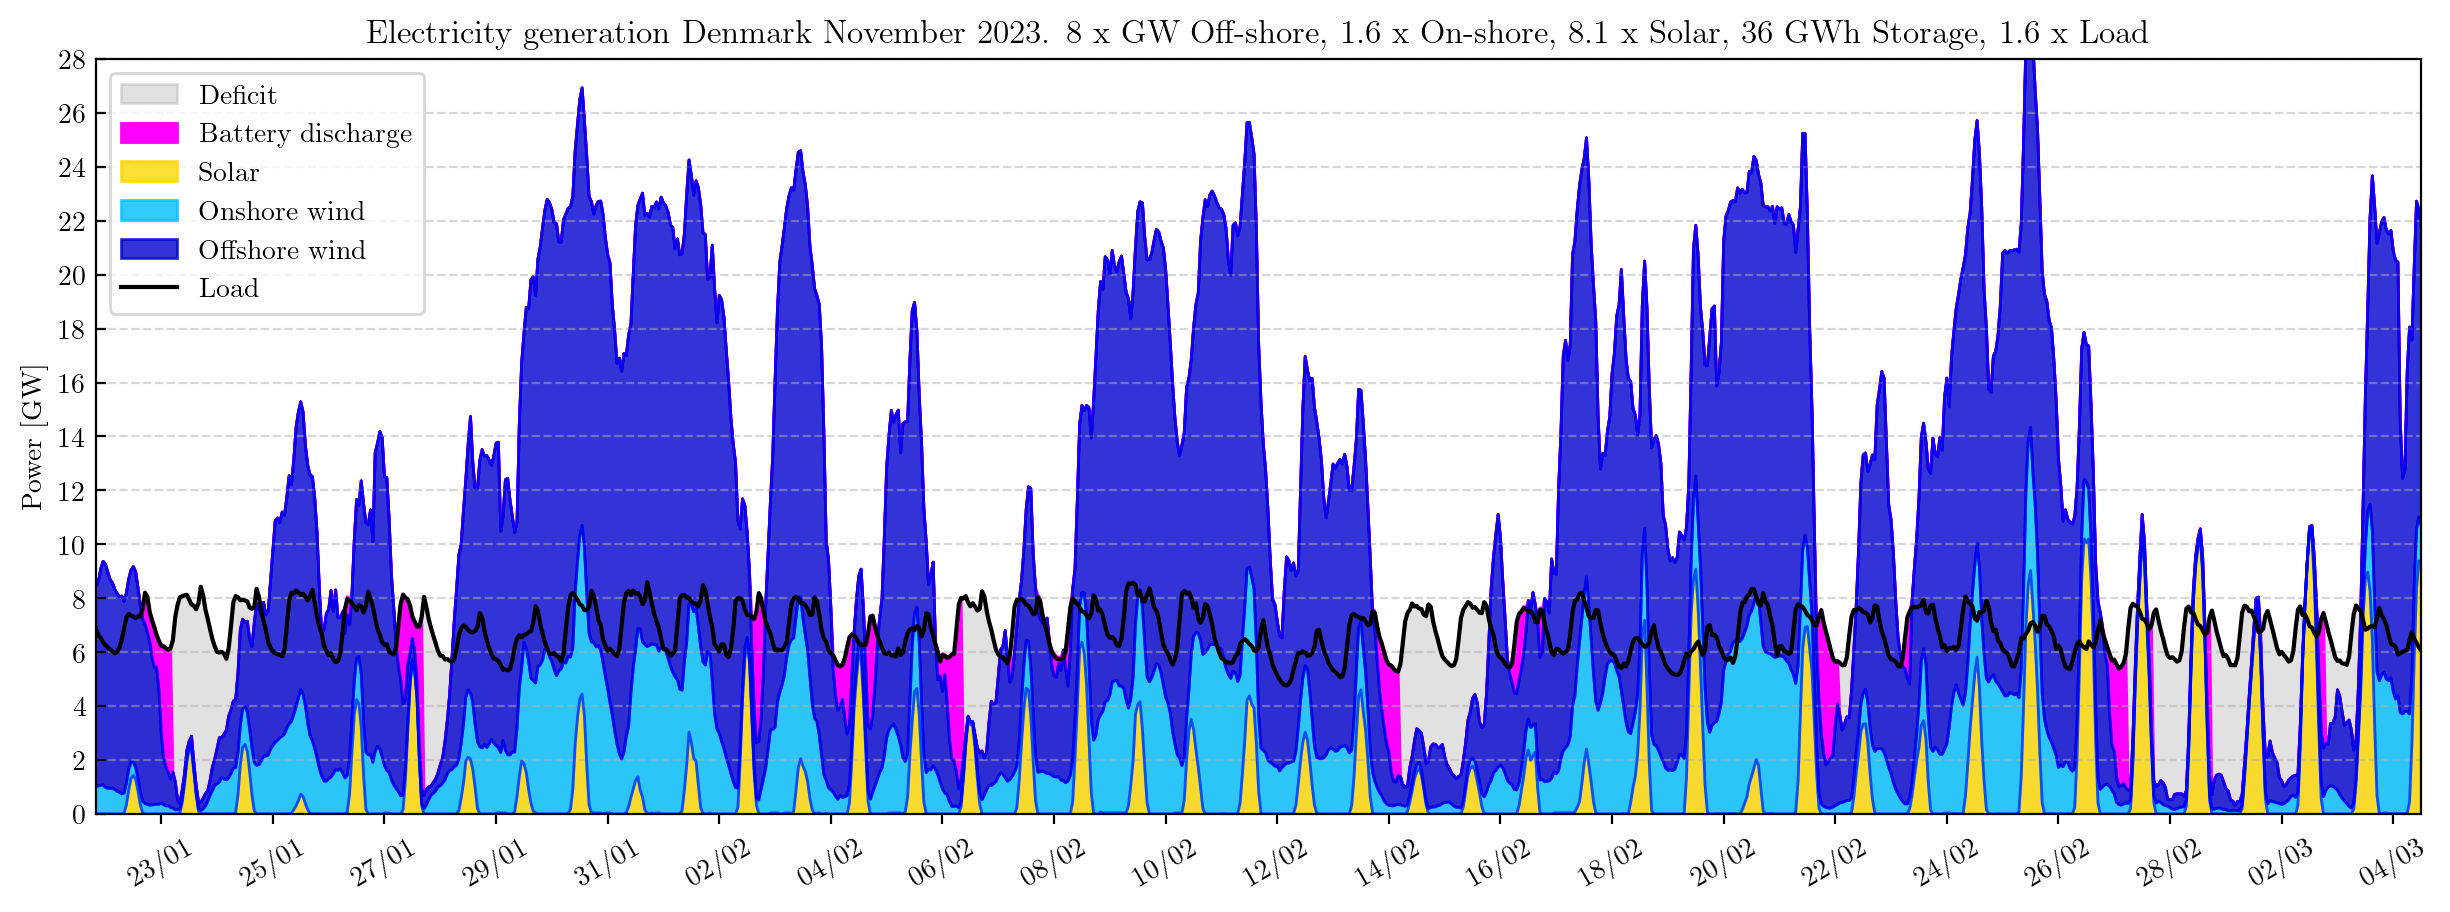

In [35]:
Q = 8
storage_list, discharge_list, charge_list = charge_discharge(Q)

plt.figure(dpi=200,figsize=(15,5))

solar = get_data(data,'SolarPower')*8.1 /1000 
wind1 = get_data(data,'OnshoreWindPower')*1.6 /1000
load = get_data(data,'TotalLoad')*1.6 / 1000
wind2 = get_data(data,'OffshoreWindPower')*Q / 1000

gen = wind1+wind2+solar

z = len(gen)
deficit_list = return_deficit(gen,load)
deficit_minus_storage = deficit_list - discharge_list

plt.fill_between(dates,load,color='dimgrey',alpha=0.2,label='Deficit')
plt.fill_between(dates,gen,gen+discharge_list,color='magenta',label='Battery discharge')

plt.plot(dates,solar,color='blue',alpha=0.6,linewidth=1)
plt.fill_between(dates,solar,label='Solar',color='gold',alpha=0.8)

plt.plot(dates,solar+wind1,color='blue',alpha=0.6,linewidth=1)
plt.fill_between(dates,solar,solar+wind1,label='Onshore wind',color='deepskyblue',alpha=0.8)

plt.plot(dates,solar+wind1+wind2,color='blue',alpha=0.6,linewidth=1)
plt.fill_between(dates,solar+wind1,solar+wind1+wind2,label='Offshore wind',color='mediumblue',alpha=0.8)

plt.plot(dates,load,color='black',label='Load')

#plt.plot(dates,list_of_deficit_lists[Q-1],color='red',label='Deficit',linewidth=1)
#plt.fill_between(dates,list_of_deficit_lists[Q-1],color='red',linewidth=1,alpha=0.2)

#plt.plot(dates,storage_list/4,color='red')

plt.ylabel('Power [GW]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xs = []
i = 0
while i < z:
    xs.append(dates[i])
    i += 48
plt.xticks(xs)

ys = np.arange(-2,30,2)
plt.yticks(ys)

plt.xlim(dates[500],dates[1500])
plt.ylim(-0,28)
plt.legend(loc='upper left')

plt.tick_params(axis='y',direction='in')

plt.grid(axis='y',linestyle='--',alpha=0.5)

plt.title('Electricity generation Denmark November 2023. 8 x GW Off-shore, 1.6 x On-shore, 8.1 x Solar, 36 GWh Storage, 1.6 x Load')
plt.savefig('Simulation.pdf')

0.03698253069144748


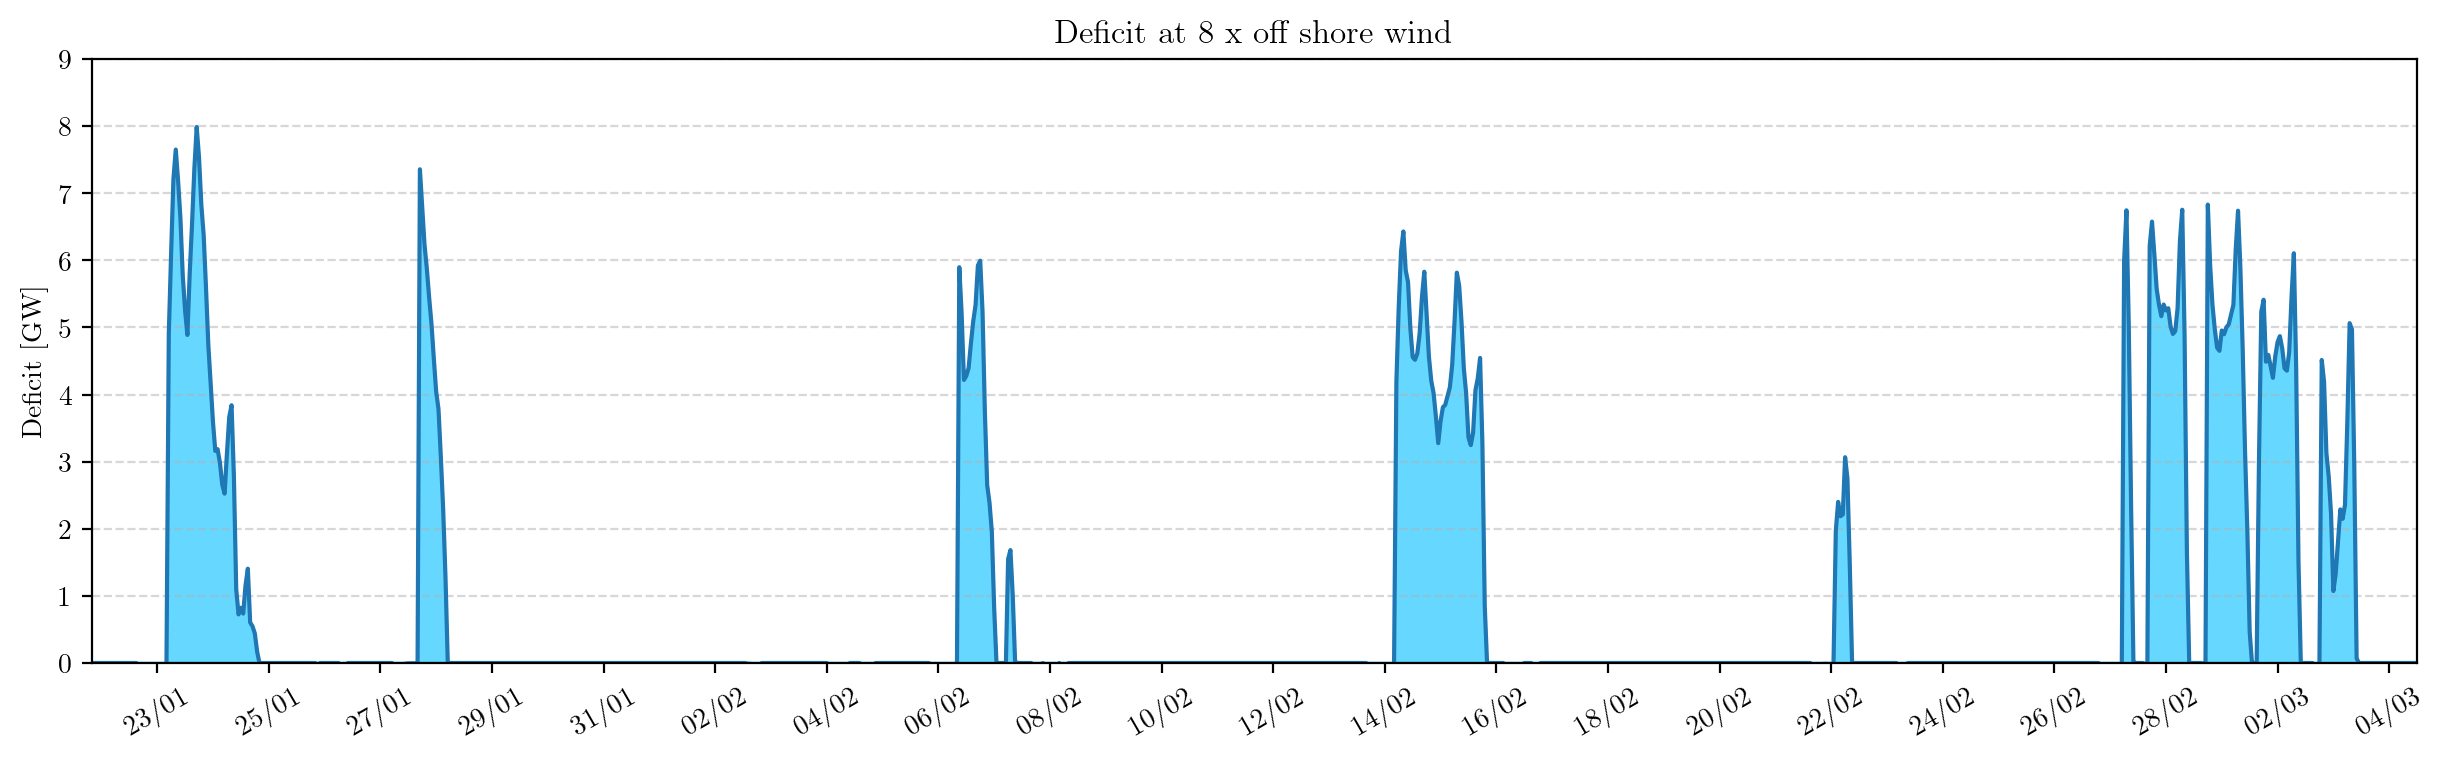

In [36]:
plt.figure(dpi=200,figsize=(15,4))
plt.plot(dates,deficit_minus_storage)
plt.fill_between(dates,deficit_minus_storage,color='deepskyblue',alpha=0.6)
plt.ylabel('Deficit [GW]')

plt.xticks(xs)

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)
plt.xlim(dates[500],dates[1500])
plt.grid(axis='y',linestyle='--',alpha=0.5)
plt.ylim(0,9)

plt.title('Deficit at 8 x off shore wind')
plt.savefig('deficit.pdf')
print(sum(deficit_minus_storage)/sum(load))

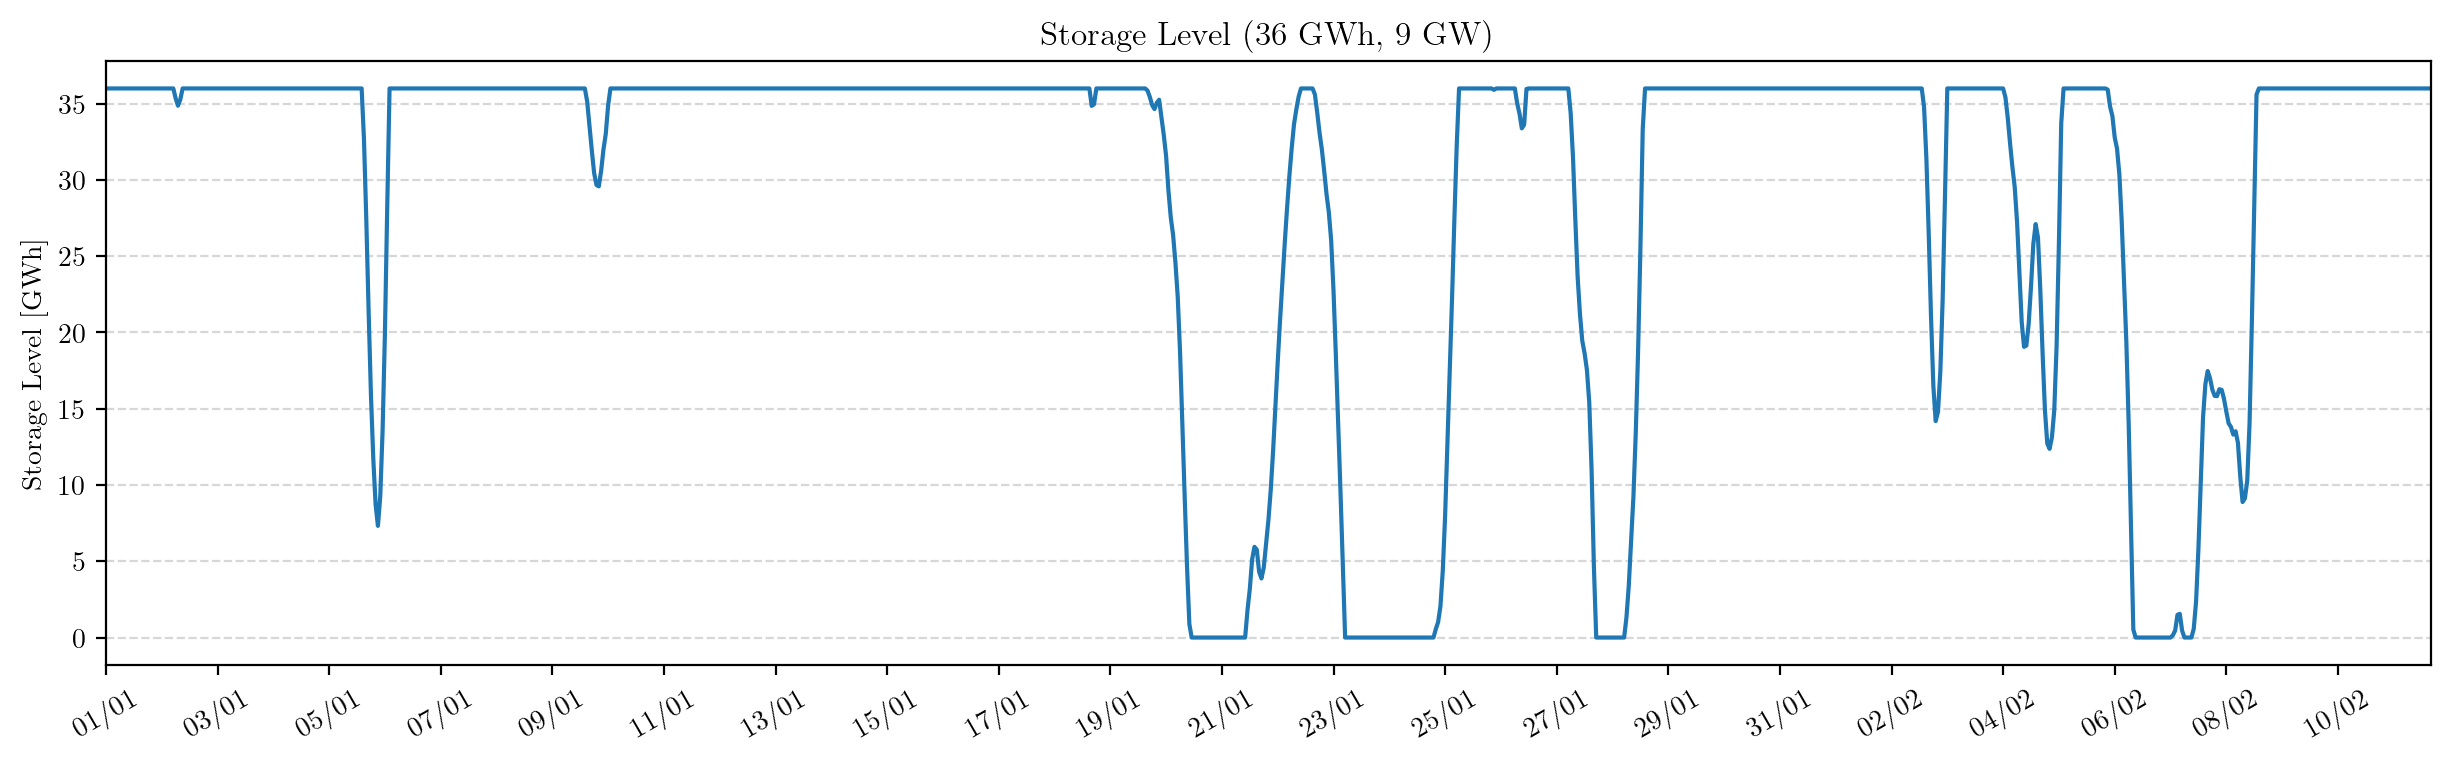

In [37]:
plt.figure(dpi=200,figsize=(15,4))
plt.plot(dates,storage_list)
plt.ylabel('Storage Level [GWh]')


plt.xticks(xs)

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)
plt.xlim(dates[0],dates[1000])
plt.grid(axis='y',linestyle='--',alpha=0.5)

plt.title('Storage Level (36 GWh, 9 GW)')
plt.savefig('storage.pdf')


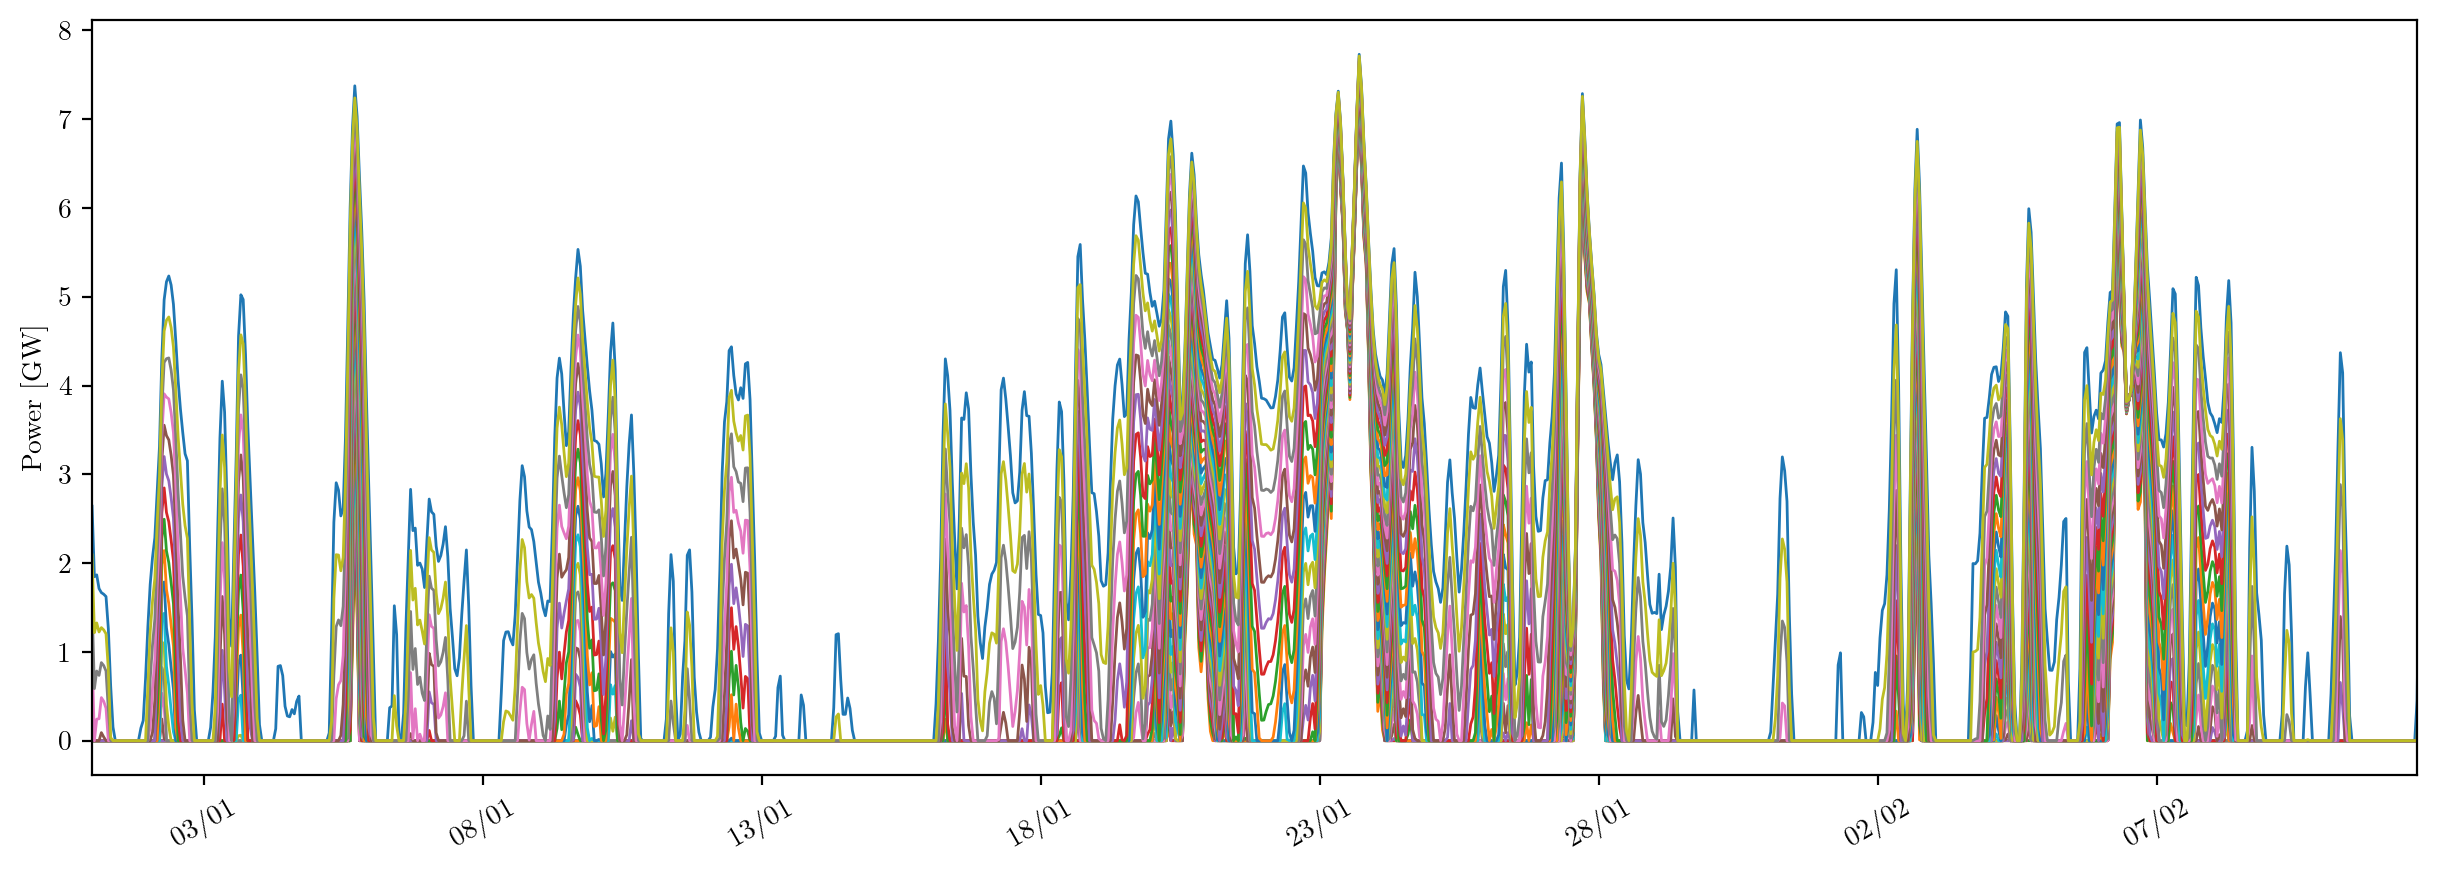

In [38]:
fig = plt.figure(dpi=200,figsize=(15,5))
for j in range(len(rng)):

    plt.plot(dates,list_of_deficit_lists[-j],linewidth=1)

plt.ylabel('Power [GW]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

plt.xlim(dates[0],dates[1000])
plt.show()

plt.show()

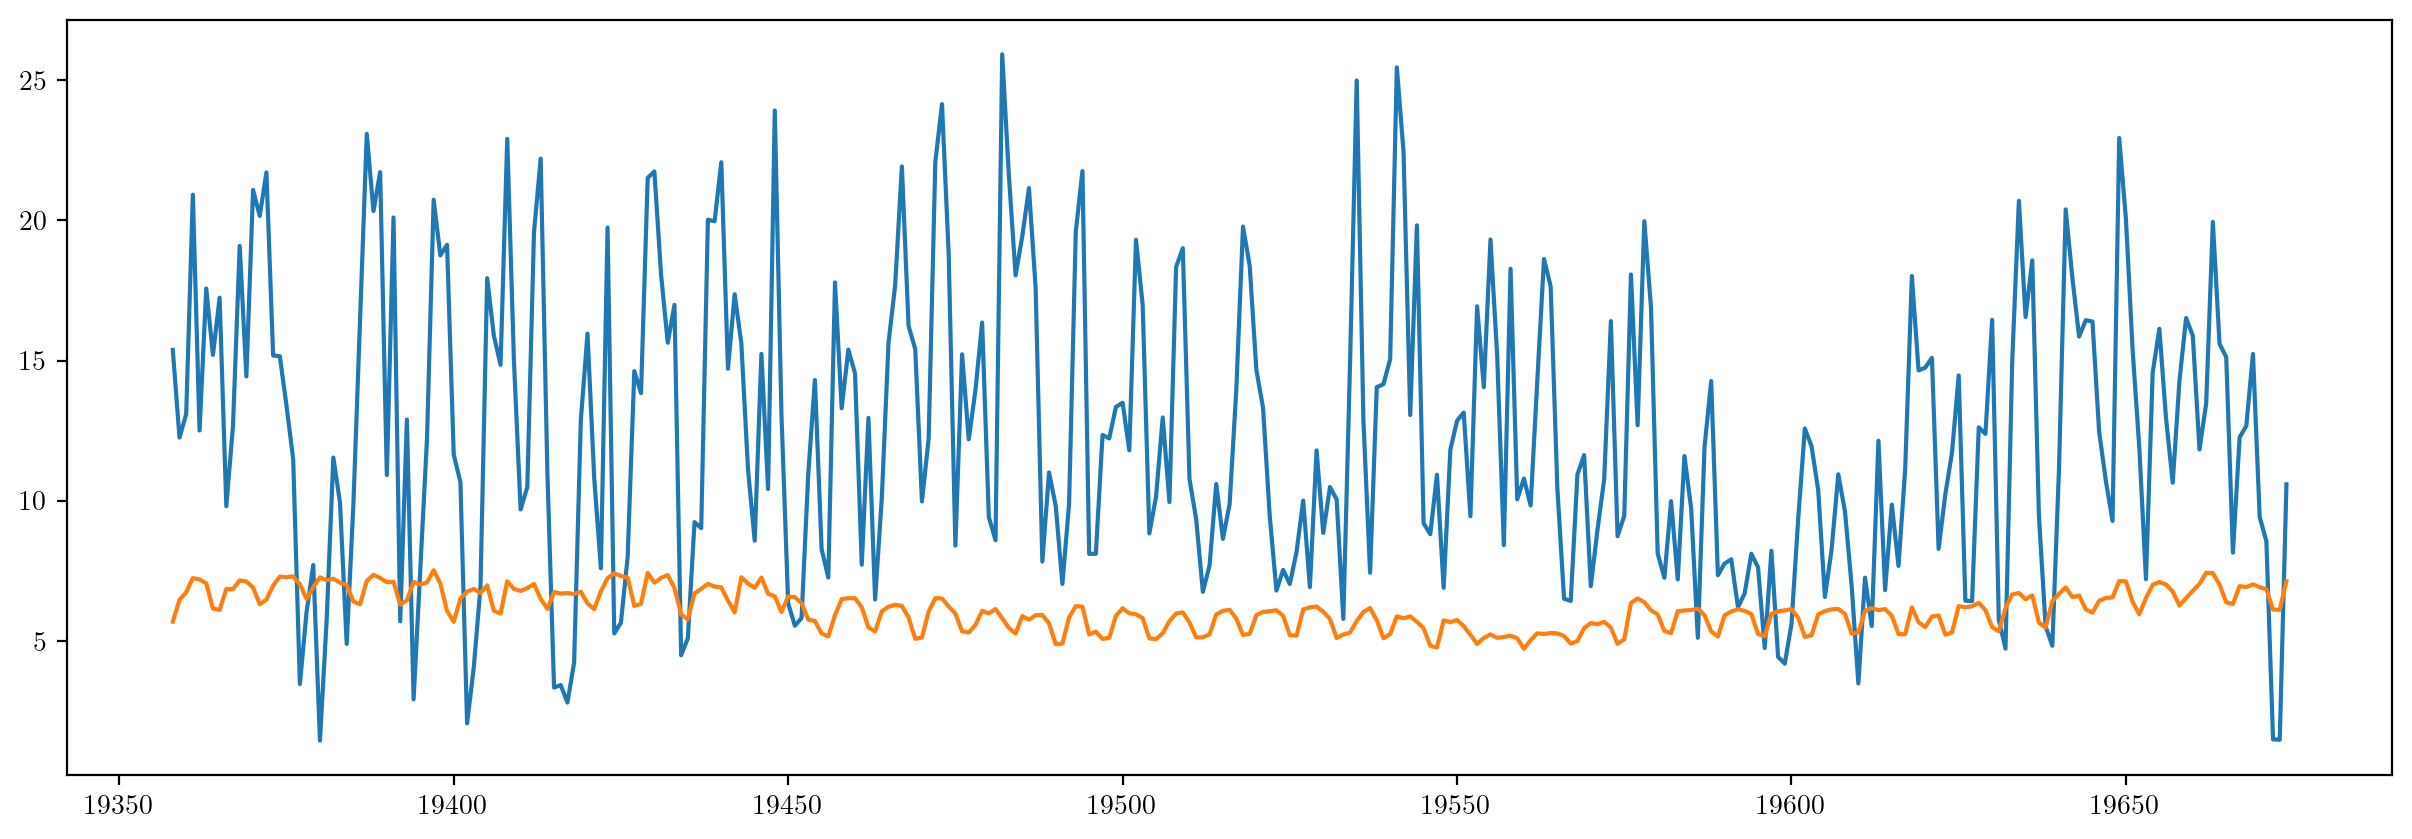